### Extração de dados gerais de despesas da prefeitura de Fortaleza

#### Período disponível: 2007 a 2020

#### Endereço: https://transparenciamunicipios.tce.ce.gov.br/index.php/municipios/despesas/mun/057/versao/2020

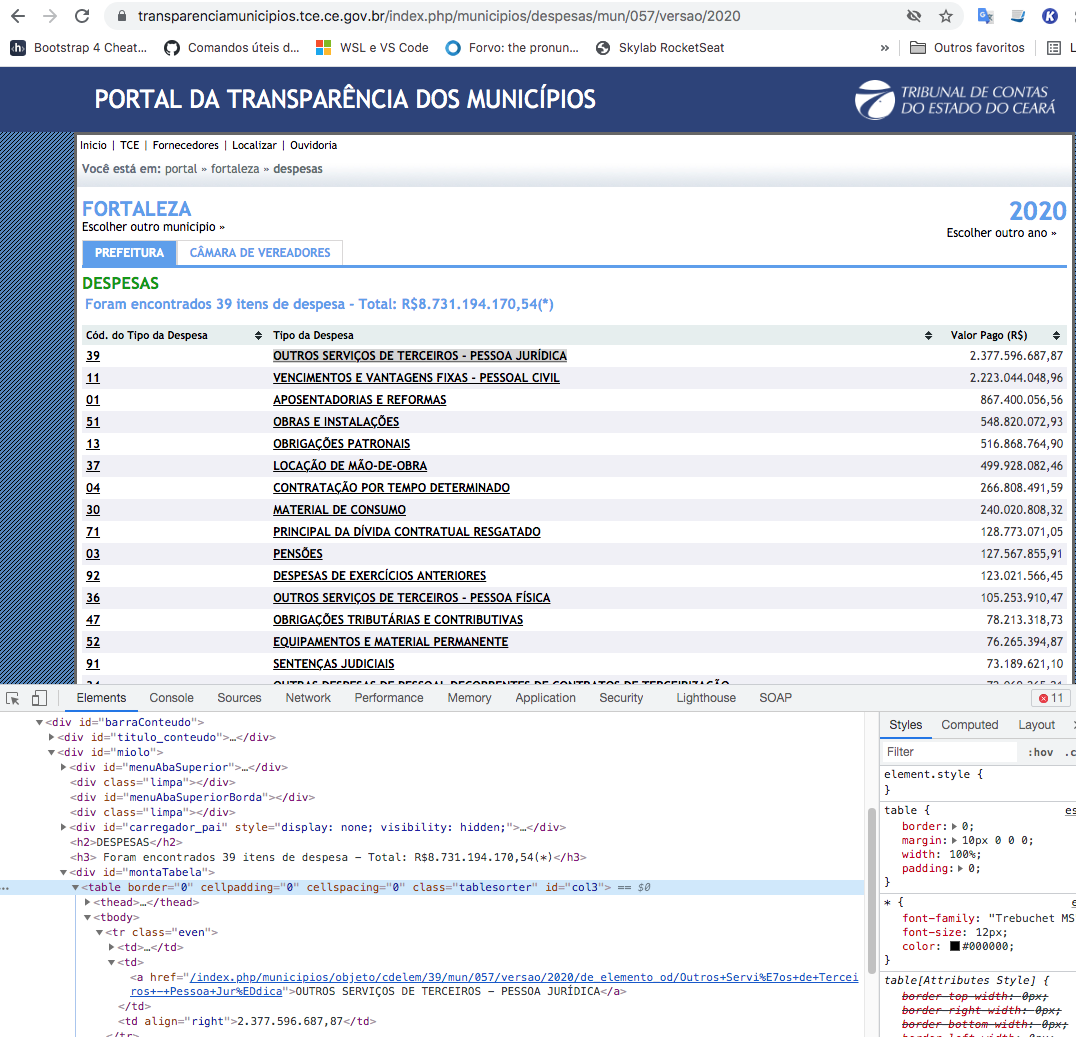

In [1]:
from bs4 import BeautifulSoup

import requests
import pandas as pd
import csv
import numpy as np

start_dt=2020 # em 2001, 2003, 2006 nao tem dados disponiveis
end_dt=2020

url_base = 'https://transparenciamunicipios.tce.ce.gov.br'

# tomando Fortaleza como exemplo
cities = { "057": "Fortaleza" } #, "162": "Sobral" }
data = []

In [2]:
def get_data(url):
    # links comecando com /index.php
    if not(url_base in url):
        url = url_base + url

    html = requests.get(url).content
    soup = BeautifulSoup(html, 'lxml') 

    tb = soup.find("tbody")
    rows = tb.find_all('tr')

    items = []
    for row in rows: 
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]

        if (not cols==[]):
            # adiciona cpf/cnpj, favorecido e valor
            items.append(cols)

    return items

In [3]:
# fazendo o scraping
# cidades
for k,v in cities.items():
    # anos
    for year in range (start_dt, end_dt+1):
        # formato: https://transparenciamunicipios.tce.ce.gov.br/index.php/municipios/despesas/mun/057/versao/2020
        url='https://transparenciamunicipios.tce.ce.gov.br/index.php/municipios/despesas/mun/'+k+'/versao/'+str(year)

        html = requests.get(url).content
        soup = BeautifulSoup(html, 'html.parser')

        tb = soup.find("tbody")

        if (tb is not None): # alguns anos nao tem dados disponiveis
            rows = tb.find_all('tr')
            items = []
            for row in rows: 
                cols = row.find_all('td')
                lnk = row.find('a').get('href')
                
                cols = [ele.text.strip() for ele in cols]

                if (not cols==[]):
                    # adiciona ano e cidade
                    cols.append(year)
                    cols.append(v)

                    #retorna dados de cada link de despesas e junta com principal
                    items = get_data(lnk)
                    for item in items:
                        data.append(cols+item) # adiciona uma vez para cada item retornado

print(data)

[['39', 'OUTROS SERVIÃ\x87OS DE TERCEIROS - PESSOA JURÃ\x8dDICA', '2.377.596.687,87', 2020, 'Fortaleza', '05.537.536/0001-64', 'ECOFOR AMBIENTAL S/A', '272.600.609,58&nbsp'], ['39', 'OUTROS SERVIÃ\x87OS DE TERCEIROS - PESSOA JURÃ\x8dDICA', '2.377.596.687,87', 2020, 'Fortaleza', '05.268.526/0001-70', 'ISGH - INSTITUTO DE SAUDE E GESTAO HOSPITALAR', '175.228.782,75&nbsp'], ['39', 'OUTROS SERVIÃ\x87OS DE TERCEIROS - PESSOA JURÃ\x8dDICA', '2.377.596.687,87', 2020, 'Fortaleza', '61.699.567/0001-92', 'SPDM ASSOCIACAO PAULISTA PARA O DESENV MEDICINA', '153.919.835,91&nbsp'], ['39', 'OUTROS SERVIÃ\x87OS DE TERCEIROS - PESSOA JURÃ\x8dDICA', '2.377.596.687,87', 2020, 'Fortaleza', '07.047.251/0001-70', 'ENEL', '96.949.593,02&nbsp'], ['39', 'OUTROS SERVIÃ\x87OS DE TERCEIROS - PESSOA JURÃ\x8dDICA', '2.377.596.687,87', 2020, 'Fortaleza', '31.340.671/0001-25', 'CONSORCIO FORVIAS', '93.041.875,48&nbsp'], ['39', 'OUTROS SERVIÃ\x87OS DE TERCEIROS - PESSOA JURÃ\x8dDICA', '2.377.596.687,87', 2020, 'Fortal

In [12]:
# verificando, removendo identificacoes
df = pd.DataFrame(data)
df.columns = ['codigo', 'tipo_despesa', 'valor_total', 'ano', 'cidade', 'cpf/cnpj', 'favorecido', 'valor_pago']

# formato atual da string valor: 1.000.000,00 -> passar para 1000000.0 e converter para float
# remove brancos e sujeira
df['valor_pago'] = df['valor_pago'].str.strip()
df['valor_pago'] = df['valor_pago'].str.replace("&nbsp", "",regex=False)
# remove pontos
df['valor_total'] = df['valor_total'].str.replace(".", "",regex=False)
df['valor_pago'] = df['valor_pago'].str.replace(".", "",regex=False)
# troca virgula por ponto
df['valor_total'] = df['valor_total'].str.replace(",", ".",regex=False)
df['valor_pago'] = df['valor_pago'].str.replace(",", ".",regex=False)
# converte para float
df['valor_total'] = df['valor_total'].astype(float)
df['valor_pago'] = df['valor_pago'].astype(float)

df

,codigo,tipo_despesa,valor_total,ano,cidade,cpf/cnpj,favorecido,valor_pago
0,39,OUTROS SERVIÃOS DE TERCEIROS - PESSOA JURÃDICA,2.377597e+09,2020,Fortaleza,05.537.536/0001-64,ECOFOR AMBIENTAL S/A,2.726006e+08
1,39,OUTROS SERVIÃOS DE TERCEIROS - PESSOA JURÃDICA,2.377597e+09,2020,Fortaleza,05.268.526/0001-70,ISGH - INSTITUTO DE SAUDE E GESTAO HOSPITALAR,1.752288e+08
2,39,OUTROS SERVIÃOS DE TERCEIROS - PESSOA JURÃDICA,2.377597e+09,2020,Fortaleza,61.699.567/0001-92,SPDM ASSOCIACAO PAULISTA PARA O DESENV MEDICINA,1.539198e+08
3,39,OUTROS SERVIÃOS DE TERCEIROS - PESSOA JURÃDICA,2.377597e+09,2020,Fortaleza,07.047.251/0001-70,ENEL,9.694959e+07
4,39,OUTROS SERVIÃOS DE TERCEIROS - PESSOA JURÃDICA,2.377597e+09,2020,Fortaleza,31.340.671/0001-25,CONSORCIO FORVIAS,9.304188e+07
...,...,...,...,...,...,...,...,...
6803,18,AUXÃLIO FINANCEIRO A ESTUDANTES,7.240000e+04,2020,Fortaleza,***.865.443-**,DOUGLAS BRAULINO BARRETO E OUTROS,5.600000e+03
6804,18,AUXÃLIO FINANCEIRO A ESTUDANTES,7.240000e+04,2020,Fortaleza,***.982.513-**,FELIPE ARTHUR CORDEIRO DE SOUZA E OUTROS,3.600000e+03
6805,18,AUXÃLIO FINANCEIRO A ESTUDANTES,7.240000e+04,2020,Fortaleza,***.010.953-**,YANDRA MARIA ARAUJO PEREIRA E OUTROS,3.200000e+03
6806,18,AUXÃLIO FINANCEIRO A ESTUDANTES,7.240000e+04,2020,Fortaleza,***.328.063-**,LUCAS PEREIRA DE OLIVEIRA E OUTROS,8.000000e+02


In [13]:
# gerando csv do df
# alterando encoding
df.to_csv (r'despesas_exp.csv', index = False, header=True)